<a href="https://www.kaggle.com/code/jrgentoppenmoen/project-2-box-office?scriptVersionId=111267709" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [141]:
#Imports, these have not been cleaned up
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from collections import Counter
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import ast
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from pathlib import Path
from pandas.plotting import scatter_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/test.csv
/kaggle/input/box-office/train.csv
/kaggle/input/box-office/test.csv


**BOX OFFICE PREDICTION**

# **1. Big picture**

As mentioned in the report belonging to this project, our model will be used as a proof of concept for predicting revenues of movies. If this is successfull, a more comprehensive model with more input can be made for production companies, cinemas and other parties involved in movies to make future decisions. Therefore an important role of the model is to gain insight as well as making predictions. We will explore all the features in the dataset, even if some of them cant be used in our interactive proof of concept


Please excuse the horrible python-code involved with the feature engineering, especially on the user-input-data. This was a real challenge, and we had to resort to a sub-optimal solution of transforming the new data into a similar format as the original training data.

**Performance measure**

We will use RMSE for performance measure as stated in the report.

# **2. Get the data**

In [3]:
DATA = Path('/kaggle/input/box-office')

In [4]:
test_df = pd.read_csv(DATA/'test.csv')
train_df = pd.read_csv(DATA/'train.csv')

The following cell is copied from https://www.kaggle.com/code/artgor/eda-feature-engineering-and-model-interpretation/comments and converts string objects into python dictionaries.

In [5]:
train_exp = train_df.copy()

In [6]:
#Copied code
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df, cols):
    for column in cols:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

train_exp = text_to_dict(train_exp, dict_columns)
#test_df = text_to_dict(test_df)

# **3. Explore data**

We have 23 columns, 1 being id and one being revenue. Meaning we have 21 features.

In [8]:
train_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  3000 non-null   object 
 2   budget                 3000 non-null   int64  
 3   genres                 3000 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   3000 non-null   object 
 12  production_countries   3000 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

18 of 21 relevant features for engineering are objects. This means we have some work to do. We will look at each object-feature, and try to gain some insights into how we should tackle these. Firstly we will look at the numerical attributes.

**Numerical attributes**

In [9]:
train_exp.drop('id', axis=1, inplace=True)

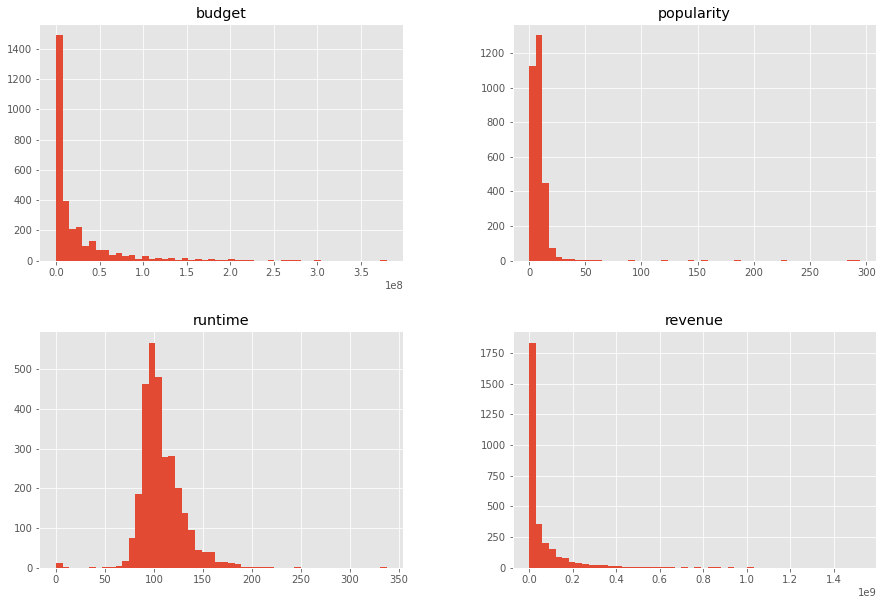

In [10]:
train_exp.hist(bins=50, figsize=(15,10))
plt.show()

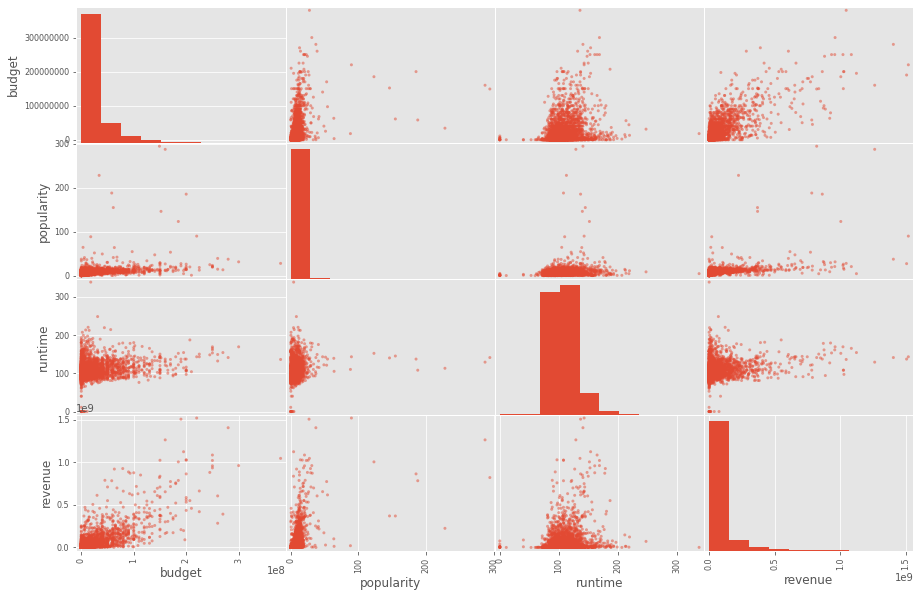

In [11]:
scatter_matrix(train_exp, figsize=(15,10))
plt.show()

In [12]:
train_exp[['revenue', 'budget']].head(15)

,revenue,budget
0,12314651,14000000
1,95149435,40000000
2,13092000,3300000
3,16000000,1200000
4,3923970,0
5,3261638,8000000
6,85446075,14000000
7,2586511,0
8,34327391,0
9,18750246,6000000


In [13]:
len(train_exp[train_exp['budget'] == 0])

812

In [14]:
len(train_exp[train_exp['revenue'] == 0])

0

Both budget and revenue are very skewed. Budget also contains 812 0-values. While some movies could theoretically have a bugdet of zero, they are most likely just missing values. We will impute these values with the mean budget.

In [15]:
#Replace budget zero with budget mean
train_exp['budget']=train_exp['budget'].replace(0,train_exp['budget'].mean())

In [16]:
#New log of budget and revenue features
train_exp['log_budget'] = np.log1p(train_exp['budget'])
train_exp['log_revenue'] = np.log1p(train_exp['revenue'])

In [17]:
#We will check correlation of old/new attributes several times so lets make a function

def show_corr(df):
    corr_matrix = df.corr()
    return corr_matrix["revenue"].sort_values(ascending=False)

In [18]:
show_corr(train_exp)

revenue        1.000000
budget         0.736115
log_revenue    0.501663
popularity     0.461460
log_budget     0.346255
runtime        0.216380
Name: revenue, dtype: float64

In [19]:
train_exp['runtime'].head(10)

0     93.0
1    113.0
2    105.0
3    122.0
4    118.0
5     83.0
6     92.0
7     84.0
8    100.0
9     91.0
Name: runtime, dtype: float64

In [20]:
len(train_exp[train_exp['runtime'] == 0])

12

In [21]:
train_exp[train_exp['runtime'].isnull()]

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,log_budget,log_revenue
1335,{},6000000.00,"[{'id': 18, 'name': 'Drama'}]",NaN,tt1107828,ru,Королёв,NaN,0.292296,/2XcRiIvliLUUGqv5qOvpc76WeCU.jpg,{},{},10/29/07,NaN,{},Released,NaN,Королёв,{},"[{'cast_id': 3, 'character': '–°–µ—Ä–≥–µ–π –ö–...","[{'credit_id': '52fe4db29251416c7513d819', 'de...",31000,15.607270,10.341775
2302,{},22531334.11,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0116485,de,Happy Weekend,NaN,0.002229,NaN,"[{'name': 'Senator Film Produktion', 'id': 191}]","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",3/14/96,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Happy Weekend,"[{'id': 572, 'name': 'sex'}, {'id': 596, 'name...","[{'cast_id': 0, 'character': 'Joachim Krippo',...",{},65335,16.930418,11.087298


Runtime is in minutes it seems, and 12 movies have 0 in runtime. 2 movies have a null value as runtime. This will need to be fixed

In [22]:
train_exp = train_exp.loc[(train_exp['runtime'] > 0)]

In [23]:
len(train_exp[train_exp['runtime'] == 0])

0

In [24]:
train_exp['popularity'].head(10)

0     6.575393
1     8.248895
2    64.299990
3     3.174936
4     1.148070
5     0.743274
6     7.286477
7     1.949044
8     6.902423
9     4.672036
Name: popularity, dtype: float64

Popularity seems to be pretty weird. I guess it is taken from a ratings system on the website where the movie data is gathered from. From the correlation it seems to be a good feature, but if we cant understand it and it is hard to reproduce when we make an interactive model, we might need to consider dropping it.

**imdb_id, poster_path**

These values are only used to access external resources. They will not be relevant for training the model, and in the preperation step we will simply remove them.

In [25]:
train_exp.drop(['imdb_id','poster_path'], axis=1, inplace=True)

**belongs_to_collection**

This could be a relevant feature, as movie collections such as "star wars" or "harry potter" are very popular. Fans are likely to watch a new film in the same series.

Lets take a look at what this attribute looks like:


In [26]:
train_exp['belongs_to_collection'].head()

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                   {}
3                                                   {}
4                                                   {}
Name: belongs_to_collection, dtype: object

In [27]:
len(train_exp[train_exp['belongs_to_collection'] != {}])

602

604 movies belong to a collection. Lets look at they way a collection is represented:

In [28]:
pd.set_option('display.max_colwidth', None)
#collection['belongs_to_collection'].head(10)

belongs to collection has an id for the collection, a name, poster path and backdrop path. Our strategy for this attribute will probably be to replace it with a 1 or 0 value for if the movie belongs to a collection or not. Lets check the correlation with revenue for such an attrbiute:

In [29]:
train_exp['belongs_to_collection'] = (train_exp['belongs_to_collection'] != {}).astype(int)

train_exp['belongs_to_collection'].head(10)

0    1
1    1
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    0
Name: belongs_to_collection, dtype: int64

In [30]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
runtime                  0.219688
Name: revenue, dtype: float64

Our new version of belongs_to_collection seems well correlated to the revenue, so we will implement this strategy.

**genres**

Lets explore genres attribute

In [31]:
train_exp['genres'].head()

0                                                                                                    [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2                                                                                                     [{'id': 18, 'name': 'Drama'}]
3                                                                     [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4                                                                    [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]
Name: genres, dtype: object

In [33]:
train_exp['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

2    969
3    899
1    585
4    391
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

It appears that most movies have 1,2 or 3 genres, while some have more with drama being the most popular. Each genre has an id. One idea for transforming these objects into numerical values could be to look at median revenue for different genres, and possible one-hot-encode the most popular genres. First we do some more exploring:

Lets get a list of genres with frequency

In [34]:
genres = list(train_exp['genres'].apply(lambda x: [i['name'] for i in x]
                                    if x != {} else []).values)

In [35]:
genres_freq = Counter([i for j in genres for i in j]).most_common()
genres_freq

[('Drama', 1528),
 ('Comedy', 1021),
 ('Thriller', 787),
 ('Action', 739),
 ('Romance', 569),
 ('Crime', 467),
 ('Adventure', 439),
 ('Horror', 300),
 ('Science Fiction', 287),
 ('Family', 260),
 ('Fantasy', 231),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 42),
 ('Foreign', 30),
 ('TV Movie', 1)]

In [36]:
top_genres = [m[0] for m in genres_freq]
top_genres

['Drama',
 'Comedy',
 'Thriller',
 'Action',
 'Romance',
 'Crime',
 'Adventure',
 'Horror',
 'Science Fiction',
 'Family',
 'Fantasy',
 'Mystery',
 'Animation',
 'History',
 'Music',
 'War',
 'Documentary',
 'Western',
 'Foreign',
 'TV Movie']

Drama is the most popular genre, with comedy, thriller, action, romance, crime and adventure following. Lets try to make a new column for each of the genres, and have values 1 if present and 0 if not for each movie. Maybe some genres are correlated to the revenue.

In [37]:
train_exp['genres'].head()

0                                                                                                    [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2                                                                                                     [{'id': 18, 'name': 'Drama'}]
3                                                                     [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4                                                                    [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]
Name: genres, dtype: object

lets make temporary column with a simple list of all the genres for a movie (instead of a list of dictionaries)

In [38]:
train_exp['genres'][0]

[{'id': 35, 'name': 'Comedy'}]

In [39]:
for g in top_genres:
    train_exp[g] = train_exp['genres'].apply(lambda x: 1 if any(d['name'] == g for d in x) else 0)

In [40]:
#genres_df.head()

show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
Adventure                0.327935
runtime                  0.219688
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
Science Fiction          0.133981
Animation                0.130482
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime                   -0.022618
War                     -0.023060
Comedy                  -0.029944
Music                   -0.032578
Horror                  -0.034280
History                 -0.044597
Foreign                 -0.047807
Romance                 -0.050126
Documentary             -0.078393
Drama                   -0.159669
Name: revenue, dtype: float64

Some of the genres are indeed correlated, if not strongly. Some good indicative genres seem to be Adventure, Action, Fantasy and Drama. This will be useful for our pipeline later.

In [41]:
train_exp.drop('genres', axis=1, inplace=True)

**homepage**

Homepage feature has a link to the movies homepage which is not in itself useful. We could however turn it into a feature that is 1 if movie has a homepage and 0 otherwise. This seems like it could be good, as most likely only big productions will make a homepage for a movie.

In [42]:
train_exp['homepage'].head()

0                                  NaN
1                                  NaN
2    http://sonyclassics.com/whiplash/
3           http://kahaanithefilm.com/
4                                  NaN
Name: homepage, dtype: object

In [43]:
train_exp['homepage'].value_counts()

http://www.transformersmovie.com/               4
http://www.thehobbit.com/                       2
http://www.lordoftherings.net/                  2
http://sonyclassics.com/whiplash/               1
https://www.facebook.com/thefinesthoursmovie    1
                                               ..
http://admiralfilm.ru/                          1
http://www.jackreachermovie.com/                1
http://www.sleepdealer.com/                     1
http://www.popperspenguins.com/main.html        1
http://www.abductionthefilm.com/                1
Name: homepage, Length: 940, dtype: int64

As suspected big productions such as transformers movies and lotr/hobbit have homepages for several of their movies

In [44]:
train_exp['homepage'] = train_exp['homepage'].notnull().astype(int)

In [45]:
train_exp['homepage'].head()

0    0
1    0
2    1
3    1
4    0
Name: homepage, dtype: int64

In [46]:
#Checking correlation

show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
Adventure                0.327935
homepage                 0.262728
runtime                  0.219688
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
Science Fiction          0.133981
Animation                0.130482
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime                   -0.022618
War                     -0.023060
Comedy                  -0.029944
Music                   -0.032578
Horror                  -0.034280
History                 -0.044597
Foreign                 -0.047807
Romance                 -0.050126
Documentary             -0.078393
Drama                   -0.159669
Name: revenue, dtype: float64

Having a homepage or not seems to be somewhat correlated, and we will implement this in the pipeline.

**orlginal_language**

In [47]:
train_exp['original_language'].head(10)

0    en
1    en
2    en
3    hi
4    ko
5    en
6    en
7    en
8    en
9    en
Name: original_language, dtype: object

In [48]:
train_exp['original_language'].value_counts()

en    2573
fr      77
es      42
hi      42
ru      42
ja      37
cn      20
it      20
ko      20
zh      19
de      17
ta      16
sv       8
nl       6
pt       6
fa       5
da       5
ro       4
hu       3
tr       3
no       2
ml       2
pl       2
te       2
fi       2
ur       1
he       1
el       1
ar       1
nb       1
vi       1
mr       1
cs       1
sr       1
bn       1
id       1
Name: original_language, dtype: int64

An overwhelming majority of movies have english as their original language. It may therefore make little sense to have a column with 1 for english as ol and 0 otherwise. Lets try it and take a look at the correlation anyway.

In [49]:
#coll_copy['belongs_to_collection'] = coll_copy['belongs_to_collection'].notnull().astype(int)

train_exp['og_language_en'] = (train_exp['original_language'] == 'en').astype(int)

In [50]:
train_exp['og_language_en'].head(10)

0    1
1    1
2    1
3    0
4    0
5    1
6    1
7    1
8    1
9    1
Name: og_language_en, dtype: int64

In [51]:
#Checking correlation
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
Adventure                0.327935
homepage                 0.262728
runtime                  0.219688
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
Science Fiction          0.133981
Animation                0.130482
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime                   -0.022618
War                     -0.023060
Comedy                  -0.029944
Music                   -0.032578
Horror                  -0.034280
History                 -0.044597
Foreign                 -0.047807
Romance                 -0.050126
Documentary             -0.078393
Drama                   -0.159669
Name: revenue,

original language in english seems to be correlated, this might need some more exploration in relation to other features.

In [52]:
train_exp.drop('original_language', axis=1, inplace=True)

**production companies**

As with genres it could be interesting to have some 1 or 0 value per the most popular production companies. We could choose a subset of companies based on how many movies they are involved in, or the median value of the movies they are involed in. Possibly both?

Lets first explore what kind of values are in this column

In [53]:
train_exp['production_companies'].head(10)

0              [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1                                                                                                     [{'name': 'Walt Disney Pictures', 'id': 2}]
2                [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3                                                                                                                                              {}
4                                                                                                                                              {}
5                                                                                                                                              {}
6                                                   [{'name': 'Ghost House Pictures', 'id': 768}, {'name': 'North Box Produc

In [54]:
train_exp['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1     771
2     729
3     581
4     312
5     166
0     153
6     118
7      62
8      41
9      29
10      7
11      7
12      3
15      2
16      2
13      1
14      1
17      1
Name: production_companies, dtype: int64

Most movies have 1 or 2 production companies, 1 movie has whopping 17 production companies! Since there are some outliers with very many prod companies, we should be careful not to make a feature based on number of companies per movie. This was not the plan either

In [55]:
comps = list(train_exp['production_companies'].apply(lambda x: [i['name'] for i in x]
                                    if x != {} else []).values)

In [56]:
comps_freq = Counter([i for j in comps for i in j]).most_common()
comps_freq[:36]

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23),
 ('Castle Rock Entertainment', 21),
 ('Epsilon Motion Pictures', 21),
 ('Morgan Creek Productions', 21),
 ('Original Film', 21),
 ('Focus 

The 35 most common production companies are all pretty well known. Lets make some new attributes to indicate if the movie is produced by some of these popular companies

In [57]:
top_comps = [m[0] for m in comps_freq][:11]

In [58]:
print(top_comps)

['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema', 'Touchstone Pictures', 'Walt Disney Pictures', 'Columbia Pictures Corporation', 'TriStar Pictures']


Having a new column for each of the most popular companies gets messy and as we can see from the correlations, not that relevant. Instead we try another strategy: An attribute that determines if the movie has a production company among the most popular ones. So a 1 if present and 0 otherwise

In [61]:
train_exp['popular_prod_comp'] = train_exp['production_companies'].apply(lambda x: 1 if any(d['name'] in top_comps for d in x) else 0)

In [62]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
Adventure                0.327935
popular_prod_comp        0.284677
homepage                 0.262728
runtime                  0.219688
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
Science Fiction          0.133981
Animation                0.130482
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime                   -0.022618
War                     -0.023060
Comedy                  -0.029944
Music                   -0.032578
Horror                  -0.034280
History                 -0.044597
Foreign                 -0.047807
Romance                 -0.050126
Documentary             -0.078393
Drama         

Making a feature popular_prod_comp that is 1 if the movie is produced by one of the 10 (can be changed) most popular companies gives a good correlation. I suspect that making the list of popular prod companies based on their median revenue could be even better.

In [63]:
train_exp.drop('production_companies', axis=1, inplace=True)

**production countries**

The first things that springs to mind is that the huge productions are mostly made in US, so we could possibly have a made_in_us column. Another interesting attribute could be number of productions countries. Lets explore some of the data before we decide: 

In [64]:
train_exp['production_countries'].head(15)

0                                             [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1                                             [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2                                             [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3                                                                [{'iso_3166_1': 'IN', 'name': 'India'}]
4                                                          [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
5                                                                                                     {}
6     [{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'CA', 'name': 'Canada'}]
7                                                                                                     {}
8                                             [{'iso_3166_1': 'US', 'name': 'United States of America'}]
9                                             [{'iso_31

In [65]:
train_exp['production_countries'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                   1752
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]                                    118
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                               93
[{'iso_3166_1': 'IN', 'name': 'India'}]                                                                                                        69
{}                                                                                                                                             54
                                                                                                                                             ... 
[{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'IN', 'name': 'India'}, {'iso_3166_1': 'FR', 'name

1752, over half of the movies are produced in the US. Lets make the made_in_us feature:

In [66]:
train_exp['made_in_us'] = train_exp['production_countries'].apply(lambda x: 1 if any (d['iso_3166_1'] == 'US' for d in x) else 0)

#lambda x: 1 if any(d['name'] == c for d in x) else 0

In [67]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
Adventure                0.327935
popular_prod_comp        0.284677
homepage                 0.262728
runtime                  0.219688
made_in_us               0.195805
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
Science Fiction          0.133981
Animation                0.130482
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime                   -0.022618
War                     -0.023060
Comedy                  -0.029944
Music                   -0.032578
Horror                  -0.034280
History                 -0.044597
Foreign                 -0.047807
Romance                 -0.050126
Documentary   

Our new attribute made_in_us is somewhat correlated. Due to the sheir number of movies made in the US, some of them are bound to be unsuccesfull or small movies as well. We will probably add this attribute as part of our pipeline.

Another idea could be to one-hot-encode each of the available countries.

In [68]:
train_exp.drop('production_countries', axis=1, inplace=True)

**Release date**

The first thought that comes to mind is that old movies would make less money. Since our model is a proof of concept of a model that could be used in the future to predict or gain insight, maybe the time of year a movie is released could be more relevant? Lets explore both options,
by adding each part of the date as a new attribute (day, month and year)

In [69]:
train_exp['release_date'][620:636]

622     9/30/16
623     6/18/93
624      6/1/01
625    12/26/59
626      3/5/93
627     4/15/16
628     11/4/16
629     8/28/98
630    10/22/04
631    10/29/70
632     7/31/91
633     6/29/05
634      2/7/68
635      4/5/84
636      8/7/81
637     2/14/08
Name: release_date, dtype: object

In [70]:
test_date = train_exp['release_date'][631]
test_date

'10/29/70'

In [71]:
def formatDate(date_str):
    year = date_str.split('/')[2]
    if int(year) <= 20:
        return date_str[:-2] + '20' + year
    else:
        return date_str[:-2] + '19' + year
    
    

In [72]:
fd = formatDate(test_date)
fd

'10/29/1970'

In [73]:
fd.split('/')[2]

'1970'

In [74]:
def dateAttribs(df):
    df['release_date'] = df['release_date'].apply(formatDate)
    
    df['release_month'] = df['release_date'].apply(lambda s: int(s.split('/')[0]))
    df['release_day'] = df['release_date'].apply(lambda s: int(s.split('/')[1]))
    df['release_year'] = df['release_date'].apply(lambda s: int(s.split('/')[2]))
    

In [75]:
dateAttribs(train_exp)

In [76]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
Adventure                0.327935
popular_prod_comp        0.284677
homepage                 0.262728
runtime                  0.219688
made_in_us               0.195805
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
release_year             0.138984
Science Fiction          0.133981
Animation                0.130482
release_day              0.045911
release_month            0.020793
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime                   -0.022618
War                     -0.023060
Comedy                  -0.029944
Music                   -0.032578
Horror                  -0.034280
History       

The date values dont seem to be correlated that much. It is surprising that release_year does not correlate better. Maybe modern films are much more hit-or-miss than I thought, since there are so many movies made. This could need some more exploring.

In [77]:
train_exp.drop('release_date', axis=1, inplace=True)

**spoken_languages**

This should be the languages that the movie is available in. The first strategy that comes to mind is to make an attribute with number of spoken languages. Dubbing the movie in several languages gives some extra cost to a movie but will most likely spread it to even more viewers which means more revenue. Lets see if that is the case

In [78]:
train_exp['spoken_languages'].head(15)

0                                             [{'iso_639_1': 'en', 'name': 'English'}]
1                                             [{'iso_639_1': 'en', 'name': 'English'}]
2                                             [{'iso_639_1': 'en', 'name': 'English'}]
3      [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4                                             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
5                                             [{'iso_639_1': 'en', 'name': 'English'}]
6                                             [{'iso_639_1': 'en', 'name': 'English'}]
7     [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso_639_1': 'en', 'name': 'English'}]
8                                             [{'iso_639_1': 'en', 'name': 'English'}]
9                                             [{'iso_639_1': 'en', 'name': 'English'}]
10                                            [{'iso_639_1': 'en', 'name': 'English'}]
11                                         

I suspect most movies to have english as their spoken language. As we can see, some movies have several spoken languages. Lets try and also make a column that is 1 if spoken language includes english, 0 otherwise

In [79]:
train_exp['spoken_lang_en'] = train_exp['spoken_languages'].apply(lambda x: 1 if any((d['name'] == 'English') for d in x) else 0)

In [80]:
train_exp['spoken_langs'] = train_exp['spoken_languages'].apply(lambda x: len(x))

In [81]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
Adventure                0.327935
popular_prod_comp        0.284677
homepage                 0.262728
runtime                  0.219688
made_in_us               0.195805
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
release_year             0.138984
Science Fiction          0.133981
spoken_lang_en           0.132765
Animation                0.130482
spoken_langs             0.063786
release_day              0.045911
release_month            0.020793
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime                   -0.022618
War                     -0.023060
Comedy                  -0.029944
Music         

Number of spoken languages is not all that correlated, spoken languages including english is somewhat correlated. We can keep the latter, if we decide to keep any of them.

In [82]:
train_exp.drop('spoken_languages', axis=1, inplace=True)

**status**

Here i am curious to see what values are present

In [83]:
train_exp['status'].value_counts()

Released    2982
Rumored        4
Name: status, dtype: int64

A vast majority of released movies. This feature can simply be dropped, without creating any new ones. It could however be useful to see if the movies with status Rumored are outliers that skew our predictions. But for now the strategy is to just drop this feature.

In [84]:
train_exp.drop('status', axis=1, inplace=True)

**cast**

With this feature there is definetly some possibility to search for mainstream popular actors among the cast. First lets see if size of cast can have any relevance.

In [85]:
train_exp['cast_size'] = train_exp['cast'].apply(lambda x: len(x))

Now lets do something similar to what we did with production companies, making a list of the most frequent cast members and making attributes by comparing cast to that list

In [86]:
casts = list(train_exp['cast'].apply(lambda x: [i['name'] for i in x]
                                    if x != {} else []).values)
casts[1]

['Anne Hathaway',
 'Julie Andrews',
 'H√©ctor Elizondo',
 'John Rhys-Davies',
 'Heather Matarazzo',
 'Chris Pine',
 'Callum Blue',
 'Larry Miller',
 'Raven-Symon√©',
 'Kathleen Marshall',
 'Caroline Goodall',
 'Lorraine Nicholson',
 'Shannon Wilcox',
 'Greg Lewis',
 'Abigail Breslin',
 'Paul Vogt',
 'Joseph Leo Bwarie',
 'Hope Alexander-Willis',
 'Rowan Joseph',
 'Jeffrey Scott Jensen']

In [87]:
cast_freq = Counter([i for j in casts for i in j]).most_common()

In [88]:
cast_freq[:11]

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23)]

Not surprisingly, the most frequent cast members are very famous actors.

In [89]:
top_actors = [m[0] for m in cast_freq][:50]

In [90]:
def cast_in_top_actors(x):
    nof = 0
    for d in x:
        if (d['name'] in top_actors):
            nof+=1
    return nof
        

In [91]:
#train_exp['popular_actors'] = train_exp['cast'].apply(lambda x: 1 if any(d['name'] in top_actors for d in x) else 0)
train_exp['nof_pop_actors'] = train_exp['cast'].apply(cast_in_top_actors)

In [92]:
#for c in top_actors:
#    train_exp[c] = train_exp['cast'].apply(lambda x: 1 if any(d['name'] == c for d in x) else 0)

In [93]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
log_budget               0.346198
belongs_to_collection    0.339993
cast_size                0.335133
Adventure                0.327935
popular_prod_comp        0.284677
homepage                 0.262728
runtime                  0.219688
nof_pop_actors           0.197183
made_in_us               0.195805
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
release_year             0.138984
Science Fiction          0.133981
spoken_lang_en           0.132765
Animation                0.130482
spoken_langs             0.063786
release_day              0.045911
release_month            0.020793
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime                   -0.022618
War           

Cast size looks good, lets keep that in mind for our pipeline. Both having seperate columns for each popular actor and having a single feature popular_actors seem to give ok-ish results. We will make our decision when making the pipeline, maybe we need to come back to this step to do some more experimenting.

In [94]:
train_exp.drop('cast', axis=1, inplace=True)

**crew**

Lets look at some values first, but I suspect we should/could drop this without much thought. It might be very useful to check which director or producer is a part of the crew, but more general crew members are irrelevant. Perhaps number of crew members could be useful, but we dont really know the quality of the data (are numbers for movies equally accurate?)

In [95]:
train_exp['crew'].head(1)

0    [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id':

These are a lot of crew members listed for a single movie. I think it would be useful to experiment with a crew_size variable, and perhaps also getting a list of popular directors and searching if any crew member with job director is in that list. 

In [96]:
train_exp['crew_size'] = train_exp['crew'].apply(lambda x: len(x))

In [97]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
crew_size                0.371407
log_budget               0.346198
belongs_to_collection    0.339993
cast_size                0.335133
Adventure                0.327935
popular_prod_comp        0.284677
homepage                 0.262728
runtime                  0.219688
nof_pop_actors           0.197183
made_in_us               0.195805
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
release_year             0.138984
Science Fiction          0.133981
spoken_lang_en           0.132765
Animation                0.130482
spoken_langs             0.063786
release_day              0.045911
release_month            0.020793
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime         

Okay so crew size is actually a pretty good attribute

In [98]:
train_exp.drop('crew', axis=1, inplace=True)

**original_title, overview, tagline, title, keywords**

These columns include a lot of text. One idea could be to make some search for each row, how many popular buzzwords like "war", "kill", "chase", "explosion" etc. appear in these text columns. This would however take a lot of time in the processing/training step. Additionally it does not really fit our project scope of making a proof of concept that can be interacted with by normal people. They would need to copy and paste a lot of text.

In [99]:
train_exp['original_title'][0]

'Hot Tub Time Machine 2'

In [100]:
train_exp['overview'][0]

'When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.'

In [101]:
train_exp['tagline'][0]

'The Laws of Space and Time are About to be Violated.'

In [102]:
train_exp['title'][0]

'Hot Tub Time Machine 2'

In [103]:
train_exp['Keywords'][0]

[{'id': 4379, 'name': 'time travel'},
 {'id': 9663, 'name': 'sequel'},
 {'id': 11830, 'name': 'hot tub'},
 {'id': 179431, 'name': 'duringcreditsstinger'}]

Our strategy will be to simply delete these columns. Keywords is the only column that could be interesting for the use mentioned above, as it only contains a few very relevant words for the movie. It is also formatted as a dictionary so searching for buzzwords would be more effective here. We will note this as a possible future improvement.

In [104]:
del_columns = ['original_title', 'overview', 'tagline', 'title', 'Keywords']
train_exp.drop(del_columns, axis=1, inplace=True)

# **Combining features**

Now we have experimented and made some useful numerical features for the train_exp dataframe. Lets take a look at them, and try to combine some of them to make useful attributes

In [105]:
train_exp.head(20)

,belongs_to_collection,budget,homepage,popularity,runtime,revenue,log_budget,log_revenue,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie,og_language_en,popular_prod_comp,made_in_us,release_month,release_day,release_year,spoken_lang_en,spoken_langs,cast_size,nof_pop_actors,crew_size
0,1,1.400000e+07,0,6.575393,93.0,12314651,16.454568,16.326300,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,20,2015,1,1,24,1,72
1,1,4.000000e+07,0,8.248895,113.0,95149435,17.504390,18.370959,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,8,6,2004,1,1,20,0,9
2,0,3.300000e+06,1,64.299990,105.0,13092000,15.009433,16.387512,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,10,10,2014,1,1,51,1,64
3,0,1.200000e+06,1,3.174936,122.0,16000000,13.997833,16.588099,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,9,2012,1,2,7,0,3
4,0,2.253133e+07,0,1.148070,118.0,3923970,16.930418,15.182615,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,2009,0,1,4,0,2
5,0,8.000000e+06,0,0.743274,83.0,3261638,15.894952,14.997740,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,8,6,1987,1,1,4,0,11
6,0,1.400000e+07,1,7.286477,92.0,85446075,16.454568,18.263396,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,8,30,2012,1,1,14,0,77
7,0,2.253133e+07,0,1.949044,84.0,2586511,16.930418,14.765821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,15,2004,1,2,4,0,1
8,1,2.253133e+07,0,6.902423,100.0,34327391,16.930418,17.351454,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,2,16,1996,1,1,12,0,8
9,0,6.000000e+06,0,4.672036,91.0,18750246,15.607270,16.746717,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,4,16,2003,1,1,20,0,11


In [106]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
log_revenue              0.504144
popularity               0.460937
crew_size                0.371407
log_budget               0.346198
belongs_to_collection    0.339993
cast_size                0.335133
Adventure                0.327935
popular_prod_comp        0.284677
homepage                 0.262728
runtime                  0.219688
nof_pop_actors           0.197183
made_in_us               0.195805
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
release_year             0.138984
Science Fiction          0.133981
spoken_lang_en           0.132765
Animation                0.130482
spoken_langs             0.063786
release_day              0.045911
release_month            0.020793
Thriller                 0.006609
TV Movie                -0.003319
Western                 -0.013292
Mystery                 -0.015228
Crime         

In [107]:
#budget to year
train_exp['budget_to_year'] = train_exp['budget']/train_exp['release_year']

#budget to runtime
train_exp['budget_to_runtime'] = train_exp['budget']/train_exp['runtime']

#Budget to number of famous actors
train_exp['budget_to_pop_actors'] = train_exp['budget']/train_exp['nof_pop_actors']

#runtime to year
train_exp['runtime_to_year'] = train_exp['runtime']/train_exp['release_year']




In [108]:
show_corr(train_exp)

revenue                  1.000000
budget                   0.735997
budget_to_year           0.735572
budget_to_runtime        0.679673
budget_to_pop_actors     0.627289
log_revenue              0.504144
popularity               0.460937
crew_size                0.371407
log_budget               0.346198
belongs_to_collection    0.339993
cast_size                0.335133
Adventure                0.327935
popular_prod_comp        0.284677
homepage                 0.262728
runtime                  0.219688
runtime_to_year          0.212763
nof_pop_actors           0.197183
made_in_us               0.195805
Action                   0.184618
Fantasy                  0.171461
Family                   0.161205
og_language_en           0.139701
release_year             0.138984
Science Fiction          0.133981
spoken_lang_en           0.132765
Animation                0.130482
spoken_langs             0.063786
release_day              0.045911
release_month            0.020793
Thriller      

# **4. Prep the data**

Here we will make our pipeline. Our **strategy** so far, based on the exploration of the data in step 3:

* belongs_to_collection: 1-hot
* budget: Keep
* genres: New feature for at least some of the genres, 1-hot
* homepage: 1-hot
* imdb_id: Drop
* original_language: 1-hot if english or not
* original_title: Drop
* overview: Drop
* popularity: Drop (because of user interaction)
* poster_path: Drop
* production_companies: 1-hot some of the most popular ones
* production_countries: 1-hot if made in us
* release_date: New feature for year (possibly month)
* runtime: Keep
* spoken_languages: 1-hot if english included
* status: Drop
* tagline: Drop
* title: Drop
* Keywords: Drop
* cast: 1-hot if present actors from popular actors list
* crew: Drop (because of user interaction)
* new combined features:
* budget to year, budget to runtime, budget to number of popular actors, runtime to year

Our results should be easy to reproduce, and our plan is to have an interactive version of the model with a ui. In this ui it is unlikely that the user will be able to fill in the whole crew and the whole cast. So these sizes should probably not be a part of our proof of concept model, but instead be a part of the final and professional model if it is made. Popularity might also need to be dropped, as we discovered early it is a weird attribute possibly gathered from a movie website

**Pipeline components**

In [109]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [110]:
#Our lists of different popular values, used for several attributes
final_pop_prod_companies = top_comps
final_pop_actors = top_actors
final_pop_genres = top_genres

In [111]:
dict_cols_after_drop = ['cast','genres','belongs_to_collection','production_companies', 'production_countries', 'spoken_languages']

In [112]:
class transform_to_dictionaries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = text_to_dict(X, dict_cols_after_drop)
        
        return X

In [113]:
class drop_irrelevant_features(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        drops = ['imdb_id','poster_path','original_title','overview','popularity','poster_path', 'status', 'tagline', 'title', 'Keywords', 'crew']
        
        X.drop(drops, axis=1, inplace=True)
        
        return X

In [114]:
class impute_zeroes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['runtime'] = X['runtime'].replace(0,X['runtime'].mean())
        X['budget'] = X['budget'].replace(0,X['budget'].mean())
                  
        return X

In [115]:
class impute_nans(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['budget'] = X['budget'].replace(np.nan, X['budget'].mean())
        X['runtime'] = X['runtime'].replace(np.nan, X['runtime'].mean())
        
        return X
        

In [116]:
class date_transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dateAttribs(X)
        
        X.drop('release_date', axis=1, inplace=True)
        
        return X
        
        

In [117]:
class add_nof_pop_actors(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #X['nof_pop_actors'] = X['cast'].apply(cast_in_top_actors)
        
        def cast_in_top_preset_actors(l):
            nof = 0
            for d in l:
                if (d.get("name") in final_pop_actors):
                    nof+=1
            return nof
        
        X['nof_pop_actors'] = X['cast'].apply(cast_in_top_preset_actors)
        
        X.drop('cast', axis=1, inplace=True)
        
        return X
        

In [118]:
class one_hot_collection(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['belongs_to_collection'] = (X['belongs_to_collection'] != {}).astype(int)
        
        return X

In [119]:
class one_hot_genres(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for g in final_pop_genres:
            X[g] = X['genres'].apply(lambda x: 1 if any(d['name'] == g for d in x) else 0)
            
        X.drop('genres', axis=1, inplace=True)
            
        return X
            
        

In [120]:
class one_hot_homepage(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['homepage'] = X['homepage'].notnull().astype(int)
        
        return X

In [121]:
class one_hot_og_language_en(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['og_language_en'] = (X['original_language'] == 'en').astype(int)
        
        X.drop('original_language', axis=1, inplace=True)
        
        return X

In [122]:
class one_hot_if_pop_prod_company(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['popular_prod_comp'] = X['production_companies'].apply(lambda x: 1 if any(d['name'] in final_pop_prod_companies for d in x) else 0)
        
        X.drop('production_companies', axis=1, inplace=True)
        
        return X

In [123]:
class made_in_us(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['made_in_us'] = X['production_countries'].apply(lambda x: 1 if any (d['iso_3166_1'] == 'US' for d in x) else 0)
        
        X.drop('production_countries', axis=1, inplace=True)
        
        return X

In [124]:
class english_spoken(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['spoken_lang_en'] = X['spoken_languages'].apply(lambda x: 1 if any((d['name'] == 'English') for d in x) else 0)
        
        X.drop('spoken_languages', axis=1, inplace=True)
        
        return X

In [125]:
class add_combined_features(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):

        #budget to year
        X['budget_to_year'] = X['budget']/X['release_year']
        #budget to runtime
        X['budget_to_runtime'] = X['budget']/X['runtime']

        #Budget to number of famous actors
        #TODO needs fixing for 0 pop actors = INF
        #X['budget_to_pop_actors'] = X['budget']/X['nof_pop_actors']

        #runtime to year
        X['runtime_to_year'] = X['runtime']/X['release_year']
        
        return X

In [126]:
#Not in use
class drop_processed_features(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X

In [127]:
#Not used
final_pipeline = Pipeline(
        steps=[ 
            ("drop_irrelevant_features", drop_irrelevant_features()),
            ("to_dictionaries", transform_to_dictionaries()),
            ("fix_dates", date_transformer()),
            ("pop_actors", add_nof_pop_actors()),
            #("zeroes_imputer", SimpleImputer(missing_values=0)),
            ("one_hot_collection", one_hot_collection()),
            ("one_hot_genres", one_hot_genres()),
            ("one_hot_homepage", one_hot_homepage()),
            ("one_hot_og_lang_en", one_hot_og_language_en()),
            ("one_hot_prod_comp", one_hot_if_pop_prod_company()),
            ("one_hot_made_in_us", made_in_us()),
            ("one_hot_english_spoken", english_spoken()),
            #("nan_imputer", SimpleImputer())
            ("add_combined_features", add_combined_features()),
            #("std_scaler", StandardScaler()) #Had to remove scaling
        ]
)

drop_and_dict = Pipeline(
        steps=[
            ("drop_irr", drop_irrelevant_features()),
            ("to_dict", transform_to_dictionaries())
              ]
)

nums = ['budget', 'runtime']

nans = Pipeline(
        steps=[("impute_nans", impute_nans())]
)

zeroes = Pipeline(
        steps=[("impute_zeroes", impute_zeroes())]
)

new_features = Pipeline(
        steps=[
            ("fix_dates", date_transformer()),
            ("pop_actors", add_nof_pop_actors()),
            ("one_hot_collection", one_hot_collection()),
            ("one_hot_genres", one_hot_genres()),
            ("one_hot_homepage", one_hot_homepage()),
            ("one_hot_og_lang_en", one_hot_og_language_en()),
            ("one_hot_prod_comp", one_hot_if_pop_prod_company()),
            ("one_hot_made_in_us", made_in_us()),
            ("one_hot_english_spoken", english_spoken())
        ]
)

combining_features = Pipeline(
        steps=[
            ("add_combined_features", add_combined_features())
        ]
)

scaling_features = Pipeline(
        steps=[
            ("std_scale", StandardScaler())
        ]
)

test_pipe = Pipeline(
        steps=[
            ("test", one_hot_genres())
        ]
)

#1. Fjerne irrelevante features og #2 Tekst -> Dictionaries
#3. Impute NaN og 0 i budget og runtime
#4. Adde nye features
#5. Combine og adde nye features
#6. Scale features

def toDf(X):
    return pd.DataFrame(X)

def raw_data_pipeline(X):
    X_prep1 = toDf(drop_and_dict.fit_transform(X))
    X_df1 = toDf(X_prep1)
    X_prep2 = nans.fit_transform(X_df1)
    X_df2 = toDf(X_prep2)
    X_prep3 = zeroes.fit_transform(X_df2)
    X_df3 = toDf(X_prep3)
    X_prep4 = new_features.fit_transform(X_df3)
    X_df4 = toDf(X_prep4)
    X_prep5 = combining_features.fit_transform(X_df4)
    #X_df5 = toDf(X_prep5)
    #X_prep6 = scaling_features.fit_transform(X_df5)
    #X_df6 = toDf(X_prep6)
    
    return X_prep5
    
    
#For the user input data we will make a pipeline function like this:
def user_input_pipeline(budget, runtime, collection, homepage, english, og_english, made_in_us, date, comps, actors, genres):
    
    #Format of input
    #5500002423 True True True True True 2011-05-19 Paramount, Fox Movies Tom Cruise, Tom Hanks Action, Heroic, Drama, Adventure
    
    if collection:
        coll_string = '[{\'yes\'}]' 
    else: 
        coll_string = '{}'
    
    genres_string = '['
    for s in genres.split(', '):
        genres_string += '{\'name\': \'' + s + '\'},'
    genres_string = genres_string[:-1] + ']'
        
    if homepage:
        homepage_string = 'yes' 
    else:
        homepage_string = np.nan
        
    if og_english:
        og_lang_string = 'en'
    else:
        og_lang_string = 'placeholder'
        
    comps_string = '['
    for s in comps.split(', '):
        comps_string += '{\'name\': \'' + s + '\'},'
    comps_string = comps_string[:-1] + ']'
    
    if made_in_us:
        countries_string = '[{\'iso_3166_1\': \'US\', \'name\': \'United States of America\'}]'
    else:
        countries_string = '{}'
    
    #2010-11-17
    date_str = str(date)
    #print(date_str)
    date_string = ''
    date_arr = date_str.split('-')
    #print(date_arr)
    date_string += date_arr[1]
    date_string += r'/'
    date_string += date_arr[2]
    date_string += r'/'
    date_string += date_arr[0][2:4]
    
    #print(date_arr[0], date_arr[1], date_arr[2][2:4])
    #print(date_string)
    
    if english:
        spoken_lang_string = '[{\'iso_639_1\': \'en\', \'name\': \'English\'}]'
    else:
        spoken_lang_string = '{}'
        
    cast_string = '['
    for s in actors.split(', '):
        cast_string += '{\'name\': \'' + s + '\'},'
    cast_string = cast_string[:-1] + ']'
    
    
    
    input_df2 = pd.DataFrame({'belongs_to_collection': coll_string,
                              'budget': budget,
                              'genres' : genres_string,
                              'homepage' : homepage_string,
                              'imdb_id' : 'placeholder',
                              'original_language' : og_lang_string,
                              'original_title' : 'placeholder',
                              'overview' : 'placeholder',
                              'popularity' : 0,
                              'poster_path' : 'placeholder',
                              'production_companies' : comps_string,
                              'production_countries' : countries_string,
                              'release_date' : date_string,
                              'runtime' : runtime,
                              'spoken_languages' : spoken_lang_string,
                              'status' : 'placeholder',
                              'tagline' : 'placeholder',
                              'title' : 'placeholder',
                              'Keywords' : 'placeholder',
                              'cast' : cast_string,
                              'crew' : 'placeholder'
                                }, index=[0])
    
    df_3 = pd.DataFrame(columns = ['belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id', 
                                   'original_language', 'original_title', 'overview', 'popularity', 'poster_path',
                                   'production_companies', 'production_countries', 'release_date', 'runtime',
                                    'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'])
    
    df_3 = df_3.append ({'belongs_to_collection': coll_string,
                              'budget': budget,
                              'genres' : genres_string,
                              'homepage' : homepage_string,
                              'imdb_id' : 'placeholder',
                              'original_language' : og_lang_string,
                              'original_title' : 'placeholder',
                              'overview' : 'placeholder',
                              'popularity' : 2.5,
                              'poster_path' : 'placeholder',
                              'production_companies' : comps_string,
                              'production_countries' : countries_string,
                              'release_date' : date_string,
                              'runtime' : runtime,
                              'spoken_languages' : spoken_lang_string,
                              'status' : 'placeholder',
                              'tagline' : 'placeholder',
                              'title' : 'placeholder',
                              'Keywords' : 'placeholder',
                              'cast' : cast_string,
                              'crew' : 'placeholder'
                                }, ignore_index = True)
    
    return raw_data_pipeline(input_df2)
    

In [128]:
#Test data that could come from anvil frontend: 4353535, 120, True, True, False, False, False, '2010-11-17', 'Fox, Paramount','Tom Hanks, Tom Cruise', 'Adventure, Action, Drama'
df2 = user_input_pipeline(4353535, 120, True, True, False, True, True, '2010-11-17', 'Fox, Paramount','Tom Hanks, Tom Cruise', 'Adventure, Action, Drama')
toDf(df2).head()
#df2.head()

,belongs_to_collection,budget,homepage,runtime,release_month,release_day,release_year,nof_pop_actors,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie,og_language_en,popular_prod_comp,made_in_us,spoken_lang_en,budget_to_year,budget_to_runtime,runtime_to_year
0,1,4353535,1,120,11,17,2010,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2165.937811,36279.458333,0.059701


In [129]:
X_train = train_df.drop(['revenue', 'id'], axis=1)
y_train = train_df['revenue']

In [130]:
X_train_prepped = raw_data_pipeline(X_train)
X_train_prepped_df = toDf(X_train_prepped) 
X_train_prepped_df.head()

,belongs_to_collection,budget,homepage,runtime,release_month,release_day,release_year,nof_pop_actors,Drama,Comedy,Thriller,Action,Romance,Crime,Adventure,Horror,Science Fiction,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie,og_language_en,popular_prod_comp,made_in_us,spoken_lang_en,budget_to_year,budget_to_runtime,runtime_to_year
0,1,14000000.00,0,93.0,2,20,2015,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,6947.890819,150537.634409,0.046154
1,1,40000000.00,0,113.0,8,6,2004,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,19960.079840,353982.300885,0.056387
2,0,3300000.00,1,105.0,10,10,2014,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1638.530288,31428.571429,0.052135
3,0,1200000.00,1,122.0,3,9,2012,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,596.421471,9836.065574,0.060636
4,0,22531334.11,0,118.0,2,5,2009,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11215.198661,190943.509407,0.058736


In [131]:
X_train_prepped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  3000 non-null   int64  
 1   budget                 3000 non-null   float64
 2   homepage               3000 non-null   int64  
 3   runtime                3000 non-null   float64
 4   release_month          3000 non-null   int64  
 5   release_day            3000 non-null   int64  
 6   release_year           3000 non-null   int64  
 7   nof_pop_actors         3000 non-null   int64  
 8   Drama                  3000 non-null   int64  
 9   Comedy                 3000 non-null   int64  
 10  Thriller               3000 non-null   int64  
 11  Action                 3000 non-null   int64  
 12  Romance                3000 non-null   int64  
 13  Crime                  3000 non-null   int64  
 14  Adventure              3000 non-null   int64  
 15  Horr

# **5. Select and train a model**

Lets evaluate Random Forests and Gradient Boosting models



In [132]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std:", scores.std())

# Random forests

In [133]:
from sklearn.ensemble import RandomForestRegressor

scores = cross_val_score(RandomForestRegressor(random_state=42), X_train_prepped, y_train,
                        scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

Scores: [81161688.24027616 89116152.67501122 90846758.65292335 77357737.4764155
 78027588.31767571]
Mean: 83301985.07246038
Std: 5629606.814526747


# Gradient boosting

In [134]:
from sklearn.ensemble import GradientBoostingRegressor

scores = cross_val_score(GradientBoostingRegressor(random_state=42), X_train_prepped, y_train,
                        scoring="neg_mean_squared_error", cv=5)
gradient_rmse_scores = np.sqrt(-scores)

display_scores(gradient_rmse_scores)

Scores: [77514566.8602682  86451282.36226006 81895536.40363868 75015991.50393943
 76152102.81644115]
Mean: 79405895.9893095
Std: 4225431.003191404


Lets use gradient boosting for our model

# **6. Fine tune model**

In [135]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        "learning_rate": [0.2, 0.3, 0.4, 0.5],
        "max_depth":[4, 8, 10, 12],
        "n_estimators":[10, 20, 30]
    }
]

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

In [136]:
grid_search.fit(X_train_prepped, y_train)

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

82988543.43225501 {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 10}
80707668.42511131 {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 20}
80706449.57967204 {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 30}
89582884.79009305 {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 10}
88902931.51119137 {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 20}
89041006.32315286 {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 30}
96098735.09145233 {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 10}
95491241.54274897 {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 20}
95606796.95868425 {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 30}
101550732.52042909 {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 10}
102968042.36004263 {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 20}
103038170.515163 {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 30}
81911167.62529258 {'learning_rate': 0.3, 'max_depth': 4, 'n_estimator

In [137]:
grid_search.best_estimator_

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=30,
                          random_state=42)

In [138]:
final_model = grid_search.best_estimator_
#Save final model?

# **7. Present solution**

Our model will be accesible through a web app that can be used to predict movie revenue based on user input.

In [139]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=078d7c670c499704c23466adff2be52f58b47192d6f98bdf65002eaf9ae6534e
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


**Endpoint for making predicitons on new data**

In [140]:
import anvil.server
import babel.numbers

anvil.server.connect("74FWEHLXQYYDP3LE77SBA66X-ZXDESCZW24ZOFPIC")

@anvil.server.callable
def get_prediction(budget, runtime, collection, homepage, english, og_english, made_in_us, date, comps, actors, genres):
    
    prepped_data_df = user_input_pipeline(budget, runtime, collection, homepage, english, og_english, made_in_us, date, comps, actors, genres)
    
    prediction = final_model.predict(prepped_data_df)
    
    pred_rounded = np.round(prediction[0])
    
    return babel.numbers.format_currency(pred_rounded, "USD", locale='en_US')

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER
